# Data Preparation brain_tumor_dataset

Link to download: https://figshare.com/articles/dataset/brain_tumor_dataset/1512427

This data was used in the following papers:
1. Cheng, Jun, et al. "Enhanced Performance of Brain Tumor Classification via Tumor Region Augmentation and Partition." PloS one 10.10 (2015).
2. Cheng, Jun, et al. "Retrieval of Brain Tumors by Adaptive Spatial Pooling and Fisher Vector Representation." PloS one 11.6 (2016). Matlab source codes are available on github https://github.com/chengjun583/brainTumorRetrieval

Infos about the dataset:
- this dataset contains 3 different classes (glioma, meningeoma and pituatary tumors), which will get converted into 0, 1 and 2
- class variability:
    - glioma: 1426 images
    - meningeoma: 708 images
    - pituatary: 930 images
- it's important to note that one tumor is sliced multiple times, meaning there aren't 1426 glioma patients in this dataset!
- the images show coronar, axial and sagittal images!

In [17]:
# To-Do:
# [X] rotate images 90 degrees to the right
# [X] decrease size of images
# [X] percentile normalize the images
# [ ] split dataset into train and validation sets
# [ ] save images as .tfrecord files

In [33]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

In [34]:
path_to_brain_tumor_dataset_folder = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/brain_tumor_dataset")
path_to_brain_tumor_dataset_pngs = path_to_brain_tumor_dataset_folder / "/brainTumorDataPublic_png"

In [21]:
#tf.experimental.numpy.experimental_enable_numpy_behavior()

# CONSTANTS
IMG_SIZE = 512
SEED = 42
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [22]:
# save all paths to the images in lists
paths_to_glioma_images = []
paths_to_meningioma_images = []
paths_to_pituitary_images = []

paths_to_glioma_images = [os.path.join(path_to_brain_tumor_dataset_pngs, "glioma", image) for image in os.listdir(os.path.join(path_to_brain_tumor_dataset_pngs, "glioma"))]
paths_to_meningioma_images = [os.path.join(path_to_brain_tumor_dataset_pngs, "meningioma", image) for image in os.listdir(os.path.join(path_to_brain_tumor_dataset_pngs, "meningioma"))]
paths_to_pituitary_images = [os.path.join(path_to_brain_tumor_dataset_pngs, "pituitary", image) for image in os.listdir(os.path.join(path_to_brain_tumor_dataset_pngs, "pituitary"))]

# remove any .DR_Store files
paths_to_glioma_images = [image for image in paths_to_glioma_images if not image.endswith(".DS_Store")]
paths_to_meningioma_images = [image for image in paths_to_meningioma_images if not image.endswith(".DS_Store")]
paths_to_pituitary_images = [image for image in paths_to_pituitary_images if not image.endswith(".DS_Store")]

# amount of images per class
print(f"Amount of glioma images: {len(paths_to_glioma_images)}")
print(f"Amount of meningioma images: {len(paths_to_meningioma_images)}")
print(f"Amount of pituitary images: {len(paths_to_pituitary_images)}")

Amount of glioma images: 1426
Amount of meningioma images: 708
Amount of pituitary images: 915


had some file size issues so I added the code below to check for them, they should be fixed though

In [6]:
# def check_shape_of_images(paths_to_images, print_file_name = False):
#     # go through all images and check their shapes
#     image_shape = None

#     for image in tqdm(paths_to_images):
#         if print_file_name:
#             print(image)
#         img = tf.io.read_file(image)
#         img = tf.image.decode_png(img, channels=3)
#         if image_shape is None:
#             image_shape = img.shape
#         elif image_shape != img.shape:
#             print("Image shapes are not the same!")
#             print(image)
#             print(image_shape)
#             print(img.shape)

# check_shape_of_images(paths_to_glioma_images)
# check_shape_of_images(paths_to_meningioma_images)
# check_shape_of_images(paths_to_pituitary_images, print_file_name=False)

In [23]:
print("Training Dataset")
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = path_to_brain_tumor_dataset_pngs,
    labels = "inferred",
    label_mode = "int",
    validation_split = 0.2,
    subset = "training",
    seed = SEED,
    shuffle = True,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE
)

print()

print("Validation Dataset")
val_ds = tf.keras.utils.image_dataset_from_directory(
    path_to_brain_tumor_dataset_pngs,
    labels = "inferred",
    label_mode = "int",
    validation_split = 0.2,
    subset = "validation",
    seed = SEED,
    shuffle = True,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE
)

class_names = train_ds.class_names
print(f"\nClass Names\n{class_names}")
print("Train dataset size:", train_ds.cardinality().numpy())
print("Val dataset size:  ", val_ds.cardinality().numpy())

Training Dataset
Found 3049 files belonging to 3 classes.
Using 2440 files for training.

Validation Dataset
Found 3049 files belonging to 3 classes.
Using 609 files for validation.

Class Names
['glioma', 'meningioma', 'pituitary']
Train dataset size: 77
Val dataset size:   20


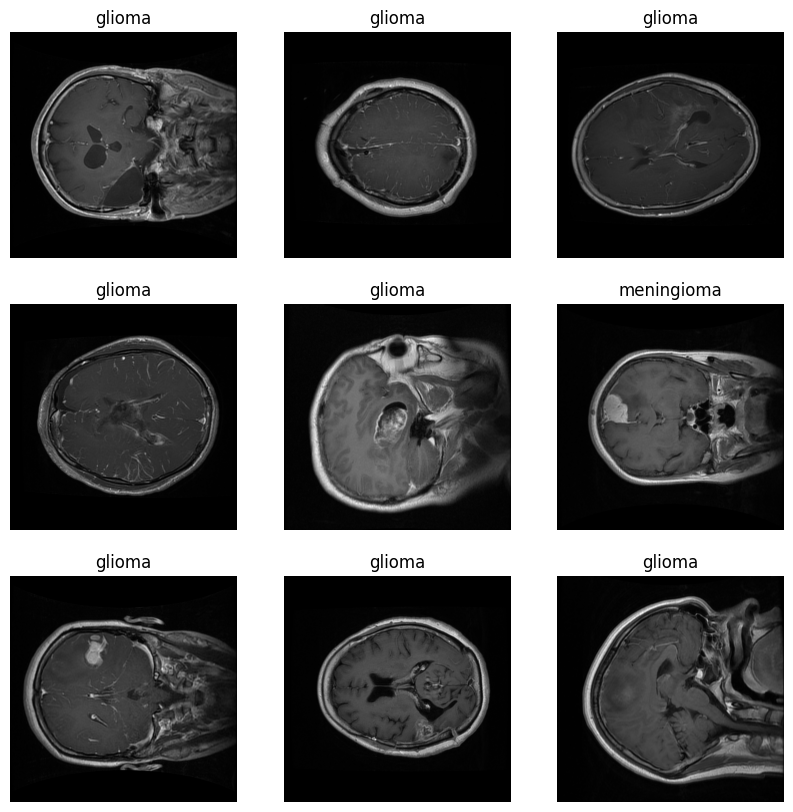

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [26]:
def data_preprocessing(image, label):
    # Rotate the image 90 degrees counter-clockwise
    image = tf.image.rot90(image, k=-1)

    print("Shape before zoom: ",image.shape)

    image = zoom_out(image, zoom_factor=0.6)

    image = percentile_normalize(image)

    return image, label

def zoom_out(image, zoom_factor=0.5):
    # The shape is [height, width, channels]
    original_size = tf.shape(image)[:2]  # should be [512, 512] if you used image_size=(512,512)
    new_size = tf.cast(tf.cast(original_size, tf.float32) * zoom_factor, tf.int32)
    
    # Resize to the smaller dimensions
    resized_image = tf.image.resize(image, new_size)
    
    # How much difference in height/width remains
    delta_height = original_size[0] - new_size[0]
    delta_width = original_size[1] - new_size[1]
    
    # Pad back to original_size
    padded_image = tf.image.pad_to_bounding_box(
        resized_image,
        offset_height=delta_height // 2,
        offset_width=delta_width // 2,
        target_height=original_size[0],
        target_width=original_size[1]
    )
    return padded_image

# Percentile normalization (scaling between 1st and 99th percentiles)
def percentile_normalize(img):
    flat_img = tf.reshape(img, [-1])
    sorted_img = tf.sort(flat_img)
    n = tf.shape(sorted_img)[0]
    p1_idx = tf.cast(tf.math.round(0.01 * tf.cast(n, tf.float32)), tf.int32)
    p99_idx = tf.cast(tf.math.round(0.99 * tf.cast(n, tf.float32)), tf.int32)
    p1 = sorted_img[p1_idx]
    p99 = sorted_img[p99_idx]
    img = tf.clip_by_value(img, p1, p99)
    img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img))
    return img

unbatch, apply preprocessing, rebatch the datasets

In [27]:
# 1) Unbatch to make each image-labeled pair its own item
train_ds = train_ds.unbatch()

# 2) Now each `image` in the dataset has shape (512, 512, 3).
#    We can safely apply our single-image preprocessing:
train_ds = train_ds.map(data_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)

# 3) Finally, rebatch for training in batches of 32
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


val_ds = val_ds.unbatch()
val_ds = val_ds.map(data_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Shape before zoom:  (512, 512, 3)
Shape before zoom:  (512, 512, 3)


In [11]:
# turn datasets into datasets that are prefetched and batched

# train_ds = (
#     train_ds
#     .shuffle(1000, seed = SEED)
#     .map(data_preprocessing, num_parallel_calls = AUTOTUNE)
#     #.batch(BATCH_SIZE, drop_remainder = True)
#     .prefetch(buffer_size = AUTOTUNE)
# )

# val_ds = (
#     val_ds
#     .map(data_preprocessing, num_parallel_calls = AUTOTUNE)
#     #.batch(BATCH_SIZE, drop_remainder = True)
#     .prefetch(buffer_size = AUTOTUNE)
# )

Visualize the images after rotation, size reduction and percentile normalization

Shape: (512, 512, 3)
Max value: 1.0
Mean value: 0.09498894
Min value: 0.0
Shape: (512, 512, 3)
Max value: 1.0
Mean value: 0.09404356
Min value: 0.0
Shape: (512, 512, 3)
Max value: 1.0
Mean value: 0.080175005
Min value: 0.0
Shape: (512, 512, 3)
Max value: 1.0
Mean value: 0.094224416
Min value: 0.0
Shape: (512, 512, 3)
Max value: 1.0
Mean value: 0.07991185
Min value: 0.0
Shape: (512, 512, 3)
Max value: 1.0
Mean value: 0.10693714
Min value: 0.0
Shape: (512, 512, 3)
Max value: 1.0
Mean value: 0.1580133
Min value: 0.0
Shape: (512, 512, 3)
Max value: 1.0
Mean value: 0.07067851
Min value: 0.0
Shape: (512, 512, 3)
Max value: 1.0
Mean value: 0.101805665
Min value: 0.0


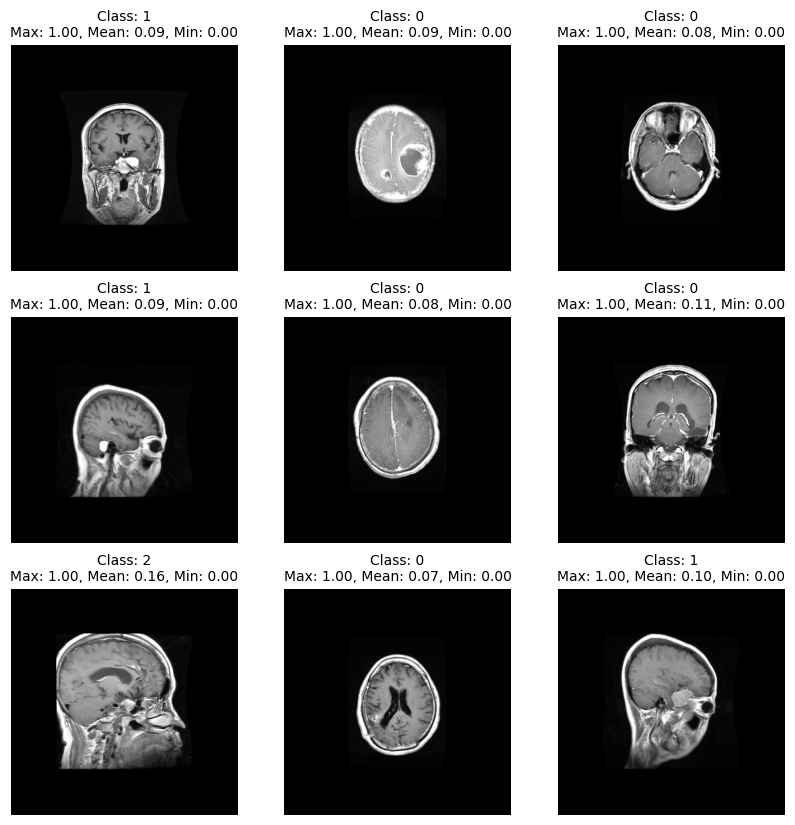

In [50]:
# Funktion zum Visualisieren von Bildern
def visualize_dataset(dataset, num_images):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy())
            #plt.suptitle(int(labels[i]))
            plt.axis("off")


            max_value = np.array(images[i]).max()
            mean_value = np.array(images[i]).mean()
            min_value = np.array(images[i]).min()
            title = f"Class: {int(labels[i])}\nMax: {max_value:.2f}, Mean: {mean_value:.2f}, Min: {min_value:.2f}"
            plt.title(title, fontsize=10)
            print("Shape:", images[i].numpy().shape)
            print("Max value:", np.array(images[i]).max())
            print("Mean value:", np.array(images[i]).mean())
            print("Min value:", np.array(images[i]).min())

# Visualisiere 9 Bilder aus dem train_ds
visualize_dataset(train_ds, 9)
plt.show()

## TFRecord creation

### Write TFRecords

In [42]:
def serialize_example(image, label):

    tumor_example = tf.train.Example(
        features = tf.train.Features(
            feature = {
                'image': tf.train.Feature(float_list = tf.train.FloatList(value = image.numpy().ravel())),
                'label': tf.train.Feature(int64_list = tf.train.Int64List(value = [label]))
            }
        )
    )

    return tumor_example.SerializeToString()

def write_dataset_to_tfrecord(dataset, tfrecord_filename):
    """
    dataset: tf.data.Dataset yielding (batch_of_images, batch_of_labels)
    tfrecord_filename: string path
    """

    options = tf.io.TFRecordOptions(compression_type="GZIP") # compress the dataset

    with tf.io.TFRecordWriter(tfrecord_filename, options) as writer:
        for batch_images, batch_labels in dataset:
            # batch_images.shape => (B, 512, 512, 3)
            # batch_labels.shape => (B,)
            for i in range(batch_images.shape[0]):
                image_i = batch_images[i]           # (512,512,3)
                label_i = batch_labels[i].numpy()   # int
                example = serialize_example(image_i, label_i)
                writer.write(example)

In [43]:
path_to_train_tfrecord = str(path_to_brain_tumor_dataset_folder / "train.tfrecord")
path_to_val_tfrecord = str(path_to_brain_tumor_dataset_folder / "val.tfrecord")

# Write training TFRecord
write_dataset_to_tfrecord(train_ds, path_to_train_tfrecord)
print("Done writing Train TFRecord")

# Write validation TFRecord
write_dataset_to_tfrecord(val_ds, path_to_val_tfrecord)
print("Done writing Validation TFRecord")

Done writing Train TFRecord
Done writing Validation TFRecord


### Read TFRecords

In [53]:
num_images = 3 #gray rgb images

feature_description = {
    "image": tf.io.FixedLenFeature([IMG_SIZE, IMG_SIZE, num_images], tf.float32),
    "label": tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def parse(serialize_tumor):
    example = tf.io.parse_single_example(serialize_tumor, feature_description)
    image = example["image"]
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, num_images])
    
    return image, example["label"]

dataset = tf.data.TFRecordDataset([path_to_train_tfrecord], compression_type="GZIP")
parsed_dataset = dataset.map(parse)
parsed_dataset = parsed_dataset.batch(32)

Image 0
  Shape: (512, 512, 3)
  Max value: 1.0
  Mean value: 0.10448375
  Min value: 0.0
Image 1
  Shape: (512, 512, 3)
  Max value: 1.0
  Mean value: 0.1257012
  Min value: 0.0
Image 2
  Shape: (512, 512, 3)
  Max value: 1.0
  Mean value: 0.08631381
  Min value: 0.0
Image 3
  Shape: (512, 512, 3)
  Max value: 1.0
  Mean value: 0.1310167
  Min value: 0.0
Image 4
  Shape: (512, 512, 3)
  Max value: 1.0
  Mean value: 0.10595015
  Min value: 0.0
Image 5
  Shape: (512, 512, 3)
  Max value: 1.0
  Mean value: 0.11389207
  Min value: 0.0
Image 6
  Shape: (512, 512, 3)
  Max value: 1.0
  Mean value: 0.12658407
  Min value: 0.0
Image 7
  Shape: (512, 512, 3)
  Max value: 1.0
  Mean value: 0.15023014
  Min value: 0.0
Image 8
  Shape: (512, 512, 3)
  Max value: 1.0
  Mean value: 0.10182536
  Min value: 0.0


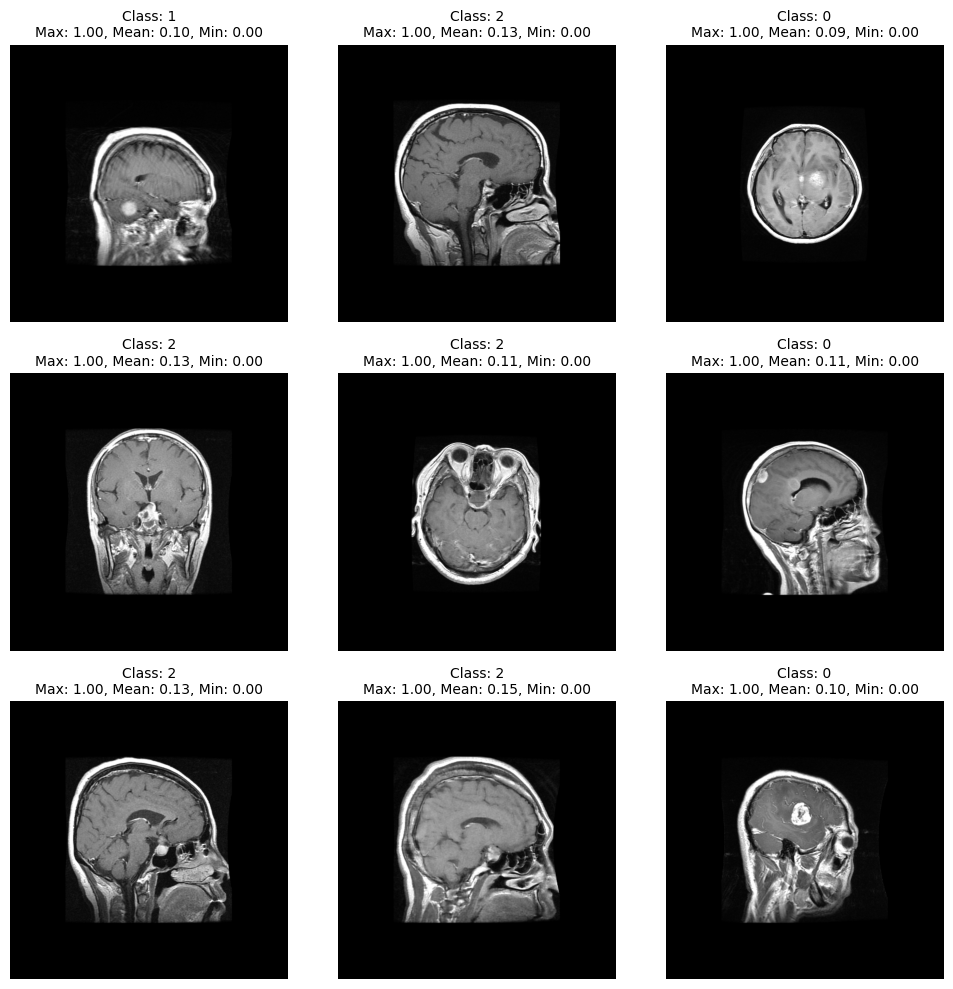

In [54]:
def visualize_tfr_dataset(dataset, num_images_to_show=9):
    """
    dataset: A tf.data.Dataset that yields (images, labels).
             Typically, images.shape = (batch_size, H, W, C),
             and labels.shape = (batch_size,).
    num_images_to_show: How many images you want to visualize from the first batch.
    """
    # Take just the first batch
    for images, labels in dataset.take(1): 
        # images.shape: (batch_size, IMG_SIZE, IMG_SIZE, 3)
        # labels.shape: (batch_size,)

        plt.figure(figsize=(10, 10))
        for i in range(num_images_to_show):
            ax = plt.subplot(3, 3, i + 1)  # 3x3 grid for 9 images
            # Convert the i-th image to a NumPy array
            img_np = images[i].numpy()

            # If your images are float [0,1], you can display directly.
            # If your images might be in other ranges, you might want to clip or normalize.
            plt.imshow(img_np)  # if grayscale => plt.imshow(img_np, cmap='gray')

            plt.axis("off")

            # Print stats
            max_value = img_np.max()
            mean_value = img_np.mean()
            min_value = img_np.min()

            title = (
                f"Class: {int(labels[i])}\n"
                f"Max: {max_value:.2f}, Mean: {mean_value:.2f}, Min: {min_value:.2f}"
            )
            plt.title(title, fontsize=10)
            print("Image", i)
            print("  Shape:", img_np.shape)
            print("  Max value:", max_value)
            print("  Mean value:", mean_value)
            print("  Min value:", min_value)

        plt.tight_layout()
        plt.show()

# Example usage, visualizing 9 images:
visualize_tfr_dataset(parsed_dataset, num_images_to_show=9)
